In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mat

from sklearn.preprocessing import StandardScaler
from tscluster.tsplot import tsplot as tsp
from tscluster.preprocessing.utils import ntf_to_tnf
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import sys
import os

sys.path.append(os.path.abspath('../'))

from codes.model.gct_model import GrangeCausalTree

# Census (ACS)

In [2]:
par_dir = ".\ACS Data\MedianIncome"

In [3]:
cols = ['GEO_ID', 'NAME', 'S1903_C02_001E']

# 'S0101_C01_001E', 'S0101_C01_030E' Age_and_Sex
# 'S1501_C01_005E' 'S1501_C01_006E' education
# 'DP03_0009PE' employment
# 'S0201_130E' ForeignBorn # Not to be used since it has only 1Y estimate data and no zipcode level data
# 'S1903_C02_001E' MedianIncome

In [4]:
ACS_code = 'S1903'
ACS_cat = 'ST'
ACS_year_est = '5Y'

In [5]:
year = 2016
census_df = pd.read_csv(par_dir + r"\ACS" + f"{ACS_cat}{ACS_year_est}" + str(year) + f".{ACS_code}-Data.csv")[cols]
print(census_df.shape)
census_df.head()

(178, 3)


,GEO_ID,NAME,S1903_C02_001E
0,Geography,Geographic Area Name,Median income (dollars)!!Estimate!!Households
1,8600000US60004,ZCTA5 60004,82407
2,8600000US60005,ZCTA5 60005,71489
3,8600000US60007,ZCTA5 60007,71089
4,8600000US60008,ZCTA5 60008,64100


In [6]:
chicago_zipcodes = np.load('Chicago_zip_codes.npy')
print(len(chicago_zipcodes))
chicago_zipcodes[:5]

67


array([60007, 60018, 60068, 60106, 60131])

In [7]:
base_cols = ['NAME'] 

features = ['S0101_C01_001E', 'S0101_C01_030E', 'S1501_C01_012E', 'S1501_C01_013E', 'S1501_C01_015E', 'S1501_C01_006E', 
            'DP03_0009PE', 'B02001_002E', 'B02001_001E', 'S1903_C02_001E']
folders = ['Age_and_Sex', 'Age_and_Sex', 'education', 'education', 'education', 'education', 'employment', 'Race', 'Race', 'MedianIncome']
ACS_categories = []
for folder in folders:
    if folder == 'employment':
        ACS_categories.append('DP')
    elif folder == 'Race':
        ACS_categories.append('DT')
    else:
        ACS_categories.append('ST')

# 'S0101_C01_001E', 'S0101_C01_030E' Age_and_Sex
# 'S1501_C01_012E' 'S1501_C01_013E', 'S1501_C01_015E' 'S1501_C01_006E' education
# 'DP03_0009PE' employment
# 'S0201_130E' ForeignBorn # Not to be used since it has only 1Y estimate data and no zipcode level data
# 'S1903_C02_001E' MedianIncome

In [8]:
gdf = gpd.read_file(r"../US_shape_file.zip")
print(gdf.shape)
gdf.head()

(33144, 6)


,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
0,35586,8600000US35586,35586,472581657,892816,"MULTIPOLYGON (((-88.0016 33.811, -88.00258 33...."
1,72454,8600000US72454,72454,263532032,775633,"POLYGON ((-90.41711 36.36553, -90.41686 36.390..."
2,71653,8600000US71653,71653,817752215,89308151,"POLYGON ((-91.45936 33.30273, -91.45758 33.381..."
3,19963,8600000US19963,19963,276290156,21123546,"POLYGON ((-75.50557 38.92751, -75.50313 38.927..."
4,81303,8600000US81303,81303,557450510,6445737,"POLYGON ((-108.04031 37.09764, -108.03896 37.1..."


In [9]:
gdf = gdf[gdf['ZCTA5CE10'].astype(int).isin(chicago_zipcodes)][['ZCTA5CE10', 'geometry']].rename(columns={'ZCTA5CE10': 'zip_code'})
gdf['zip_code'] = gdf['zip_code'].astype(int)
print(gdf.shape)
gdf.head()

(67, 2)


,zip_code,geometry
418,60176,"POLYGON ((-87.89076 41.95803, -87.8843 41.9575..."
422,60602,"POLYGON ((-87.6339 41.88447, -87.62536 41.8845..."
424,60654,"POLYGON ((-87.64774 41.8964, -87.64414 41.8964..."
1338,60624,"POLYGON ((-87.7412 41.89509, -87.72485 41.8949..."
1562,60603,"POLYGON ((-87.63382 41.88195, -87.62781 41.882..."


<Axes: >

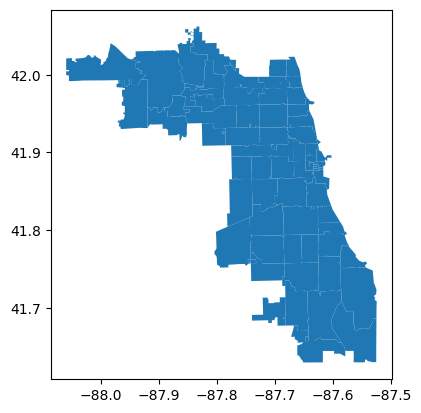

In [10]:
gdf.plot()

In [11]:
gdf_32616 = gdf.to_crs(epsg=32616)
print(gdf_32616.shape)
gdf_32616.head()

(67, 2)


,zip_code,geometry
418,60176,"POLYGON ((426180.35 4645500.031, 426715.63 464..."
422,60602,"POLYGON ((447407.353 4637143.318, 448115.672 4..."
424,60654,"POLYGON ((446268.247 4638476.457, 446567.421 4..."
1338,60624,"POLYGON ((438514.421 4638394.208, 439871.043 4..."
1562,60603,"POLYGON ((447411.175 4636863.153, 447910.573 4..."


In [12]:
census_df_lst = []

for year in range(2011, 2020):
    init_df = pd.DataFrame({'zip_code': chicago_zipcodes})

    for i in range(len(features)):
        
        par_dir = f".\ACS Data\{folders[i]}"
    
        ACS_code = features[i].split("_")[0]
        ACS_cat = ACS_categories[i]
        ACS_year_est = '5Y'

        if year > 2016 and features[i] == 'S0101_C01_030E':
            cols = base_cols + ['S0101_C01_032E']
            rename_col_dict = {'NAME': 'zip_code', 'S0101_C01_032E': 'S0101_C01_030E'}

        elif year > 2016 and features[i] == 'S1903_C02_001E':
            cols = base_cols + ['S1903_C03_001E']
            rename_col_dict = {'NAME': 'zip_code', 'S1903_C03_001E': 'S1903_C02_001E'}

        else:
            cols = base_cols + [features[i]]
            rename_col_dict = {'NAME': 'zip_code'}

        df = pd.read_csv(par_dir + r"\ACS" + f"{ACS_cat}{ACS_year_est}" + str(year) + f".{ACS_code}-Data.csv")[cols].iloc[2:, :]

        df = df.rename(columns=rename_col_dict)

        df['zip_code'] = df['zip_code'].apply(lambda x: x.split()[1]).astype(int)            

        init_df = init_df.merge(df, how='left', on='zip_code')

    init_df = init_df.replace('-', np.nan)

    float_cols = [i for i in features if i not in ('zip_code', 'S1501_C01_015E')]

    init_df.loc[:, float_cols] = init_df.loc[:, float_cols].astype(float)

    init_df['S0101_C01_001E'] = init_df['S0101_C01_001E'] / (gpd.GeoSeries(init_df.merge(gdf_32616, on='zip_code', how='left')['geometry']).area / 1_000_000)

    if year > 2014:
        init_df['S1501_C01_015E'] = 100 * (init_df['S1501_C01_012E'] + init_df['S1501_C01_013E']) / \
                                                        init_df['S1501_C01_006E']
        
    init_df['S1501_C01_015E'] = init_df['S1501_C01_015E'].astype(float)

    init_df['B02001_002E'] = init_df['B02001_002E'] / init_df['B02001_001E']

    init_df = init_df.drop(['S1501_C01_006E', 'S1501_C01_012E', 'S1501_C01_013E', 'B02001_001E'], axis=1)

    census_df_lst.append(init_df)

In [13]:
# for i in init_df.columns:
#     if init_df[i].dtype == 'object':
#         if init_df[i].str.contains('-').sum() > 0:
#             print(i)

In [14]:
print(census_df_lst[-1].shape)
census_df_lst[-1].head()

(67, 7)


,zip_code,S0101_C01_001E,S0101_C01_030E,S1501_C01_015E,DP03_0009PE,B02001_002E,S1903_C02_001E
0,60007,885.706607,43.8,35.764393,3.8,0.826061,82234.0
1,60018,700.693562,39.0,26.742935,4.6,0.796584,64429.0
2,60068,2029.361806,44.9,59.978647,2.9,0.902706,111740.0
3,60106,NaN,NaN,NaN,NaN,NaN,NaN
4,60131,1241.807559,39.1,18.239557,6.0,0.780139,64128.0


In [15]:
census_df_lst[6].head()

,zip_code,S0101_C01_001E,S0101_C01_030E,S1501_C01_015E,DP03_0009PE,B02001_002E,S1903_C02_001E
0,60007,899.862528,43.6,33.753715,5.7,0.817429,73026.0
1,60018,722.108373,38.4,24.621032,5.7,0.732612,59758.0
2,60068,2049.800173,44.2,57.194647,3.3,0.910579,98219.0
3,60106,NaN,NaN,NaN,NaN,NaN,NaN
4,60131,1258.240585,39.1,18.819450,6.9,0.777532,60163.0


In [16]:
sum([df.isnull().sum().sum() for df in census_df_lst])

54

In [17]:
i = 8
census_df_lst[i][census_df_lst[i]['S1903_C02_001E'].isnull()]

,zip_code,S0101_C01_001E,S0101_C01_030E,S1501_C01_015E,DP03_0009PE,B02001_002E,S1903_C02_001E
3,60106,NaN,NaN,NaN,NaN,NaN,NaN


dropping zip code 60106

In [18]:
census_df_lst = [df[df['zip_code'] != 60106].copy().sort_values(by='zip_code', ascending=True).set_index('zip_code') for df in census_df_lst]
sum([df.isnull().sum().sum() for df in census_df_lst])

0

In [19]:
#asserting order of zipcodes
zip_codes = np.array(census_df_lst[0].index)

for i in range(len(census_df_lst)):
    assert (np.array(census_df_lst[i].index) != zip_codes).sum() == 0

In [20]:
census_arr = np.array([census_df.values for census_df in census_df_lst])
print(census_arr.shape)
census_arr[:3, :3, :]

(9, 66, 6)


array([[[904.5900719582298, 41.6, 33.7, 5.3, 0.8038266209991732,
         69616.0],
        [667.8715145290847, 38.1, 21.1, 7.1, 0.6879147747118407,
         53459.0],
        [2020.6334846978789, 44.3, 51.4, 5.5, 0.935823138012449,
         90177.0]],

       [[903.7620841162933, 42.9, 35.1, 5.3, 0.8186896001418565,
         68184.0],
        [675.4996663017362, 38.3, 22.8, 8.2, 0.7157164070863694,
         57171.0],
        [2020.3082056436776, 44.4, 53.4, 5.7, 0.9350077818923416,
         86621.0]],

       [[907.3945469067244, 43.5, 35.7, 7.3, 0.8128808171194772,
         67473.0],
        [670.6475085992545, 39.9, 22.4, 8.1, 0.7168945006782844,
         54688.0],
        [2028.7112478772087, 44.5, 53.8, 5.5, 0.9319366131316641,
         87119.0]]], dtype=object)

In [21]:
census_features = [
    'Population Density',
    'Median age (years)',
    'Percent BA or higher',
    'Percent Unemployed',
    'Percent White',
    'Household Income'
]

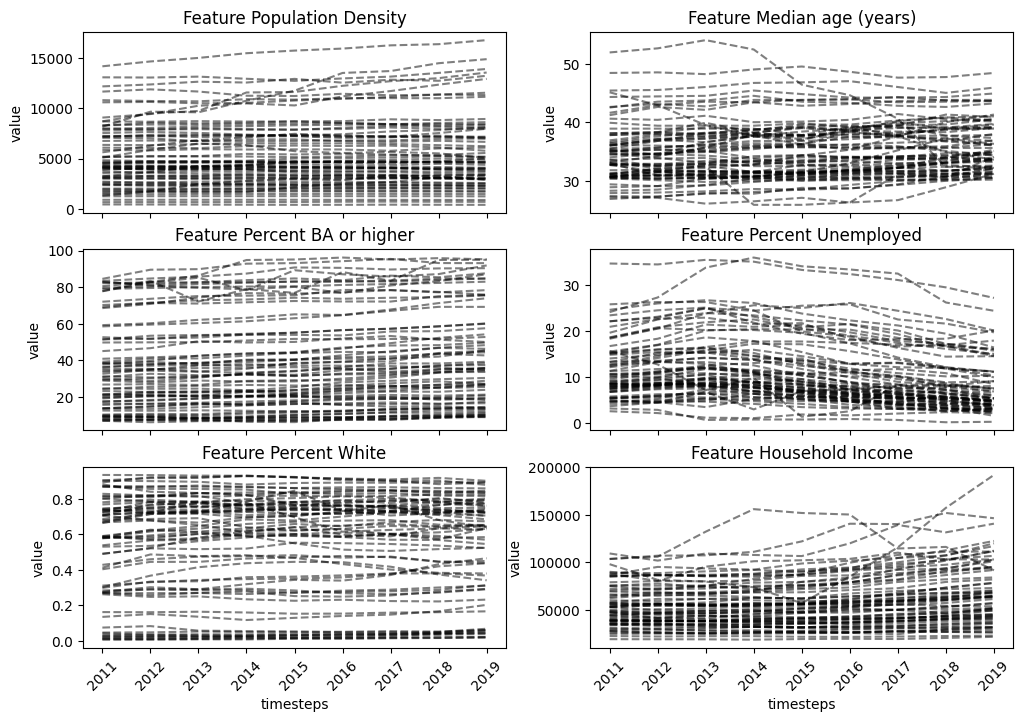

In [22]:
label_dict = {
    'T': np.arange(2011, 2020),
    'F': census_features
}

fig, ax = tsp.plot(X=census_arr, label_dict=label_dict, figsize=(12, 8), shape_of_subplot=(3, 2))
plt.show()

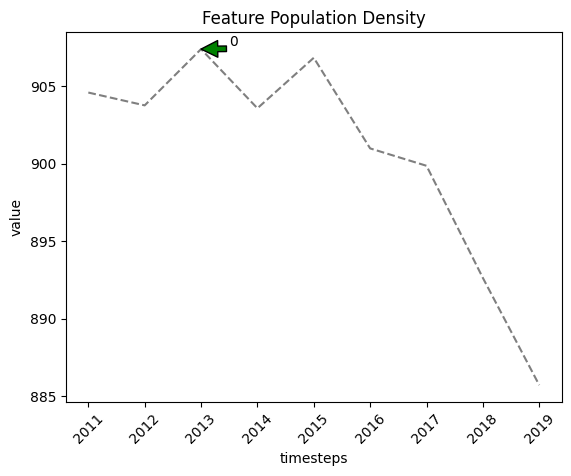

In [23]:
ei = 0
fig, ax = tsp.plot(X=census_arr[:, [ei], :1], label_dict=label_dict, entity_idx=[ei])
plt.show()

Scaling per entity

In [24]:
def scale_per_entity(X):
    ar = []
    for i in range(X.shape[1]):
        sc = StandardScaler()
        ar.append(sc.fit_transform(X[:, i, :]))

    return ntf_to_tnf(np.array(ar))

In [25]:
census_arr_scaled = scale_per_entity(census_arr)

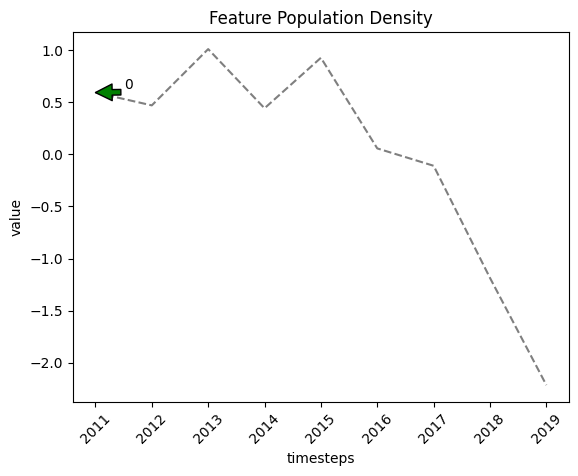

In [26]:
ei = 0
fig, ax = tsp.plot(X=census_arr_scaled[:, [ei], :1], label_dict=label_dict, entity_idx=[ei])
plt.show()

# Clustering

In [27]:
ts_arr = np.copy(census_arr_scaled)
ts_arr.shape

(9, 66, 6)

In [28]:
y_var = ['HouseholdIncome']
x_vars = [
    'PopulationDensity',
    'MedianAge',
    'PercentBAorHigher',
    'PercentUnemployed',
    'PercentWhite'
    ]

vars = y_var + x_vars

# Map

In [29]:
gdf = gdf[gdf['zip_code'] != 60106]
gdf.shape

(66, 2)

In [30]:
chicago_zipcodes = np.array(census_df_lst[0].index)

aligning the ordering of the zipcodes

In [31]:
gdf = gdf.set_index('zip_code')#.loc[zip_codes[chicago_mask], :].loc[chicago_zipcodes[chicago_mask2]]
print(gdf.shape)
gdf.head()

(66, 1)


,geometry
zip_code,
60176,"POLYGON ((-87.89076 41.95803, -87.8843 41.9575..."
60602,"POLYGON ((-87.6339 41.88447, -87.62536 41.8845..."
60654,"POLYGON ((-87.64774 41.8964, -87.64414 41.8964..."
60624,"POLYGON ((-87.7412 41.89509, -87.72485 41.8949..."
60603,"POLYGON ((-87.63382 41.88195, -87.62781 41.882..."


In [32]:
gct = GrangeCausalTree(k=3, maxlag=1, fit_intercept=True)
gct.fit(ts_arr)

labels = gct.labels_
important_feature_set = gct.important_feature_set_

In [33]:
ts_arr.shape

(9, 66, 6)

In [34]:

years = list(map(str, range(2012, 2020))) # change in current year wrt prev year

gdf['label'] = list(map(lambda x: f" {tuple([x_vars[i] for i in important_feature_set[x]])}", labels))

for t in range(len(years)):
    gdf[[v + "_" + years[t] for v in x_vars + y_var]] = ts_arr[t, :, :]

gdf.head()

,geometry,label,PopulationDensity_2012,MedianAge_2012,PercentBAorHigher_2012,PercentUnemployed_2012,PercentWhite_2012,HouseholdIncome_2012,PopulationDensity_2013,MedianAge_2013,...,PercentBAorHigher_2018,PercentUnemployed_2018,PercentWhite_2018,HouseholdIncome_2018,PopulationDensity_2019,MedianAge_2019,PercentBAorHigher_2019,PercentUnemployed_2019,PercentWhite_2019,HouseholdIncome_2019
zip_code,,,,,,,,,,,,,,,,,,,,,
60176,"POLYGON ((-87.89076 41.95803, -87.8843 41.9575...","('PercentUnemployed',)",0.595242,-2.404729,-1.739747,-0.186984,-2.224873,-0.486590,0.471951,-0.409316,...,-1.676975,0.233730,-0.026533,0.192141,-1.186506,0.972125,-0.155785,-1.133592,1.238157,1.498649
60602,"POLYGON ((-87.6339 41.88447, -87.62536 41.8845...","('PercentUnemployed',)",-1.221480,-0.984732,-1.629569,0.220783,-1.194637,-1.253899,-0.819421,-0.615457,...,0.527798,-0.849167,0.182809,0.664926,0.937593,-0.615457,1.008775,-1.307717,1.169475,0.967418
60654,"POLYGON ((-87.64774 41.8964, -87.64414 41.8964...","('PercentBAorHigher',)",-1.361468,-0.671837,-1.612617,0.884533,1.181775,-0.491003,-1.395254,-0.408944,...,0.643674,-1.083304,-1.108850,0.513997,1.251349,-0.671837,1.145421,-1.262198,-0.314414,1.048239
60624,"POLYGON ((-87.7412 41.89509, -87.72485 41.8949...","('PercentBAorHigher',)",-1.049205,-2.221191,-1.738131,0.608447,-2.161506,-1.257022,0.075501,-1.181674,...,0.995571,-0.865867,0.120391,0.631183,-0.065087,0.657473,1.343139,-1.076484,1.460774,1.458897
60603,"POLYGON ((-87.63382 41.88195, -87.62781 41.882...","('PopulationDensity',)",-0.465325,-1.657072,-0.788233,0.147667,0.028343,-0.298761,0.230143,-1.283296,...,0.027293,-0.871234,0.524218,1.300940,-0.949128,1.183623,-1.627849,-1.225635,1.072847,1.031529


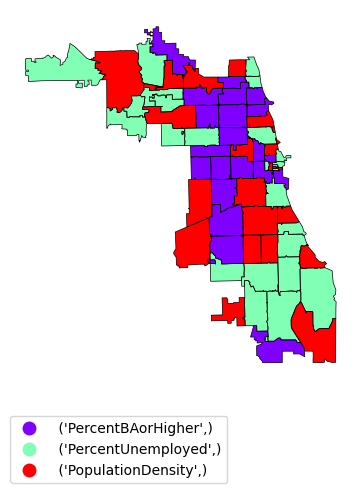

In [35]:
cmap = mat.colormaps.get_cmap('rainbow')

k = len(np.unique(labels))

norm = plt.Normalize(vmin=0, vmax=k-1)

gdf.plot(column='label', legend=True, categorical=True, cmap=cmap, legend_kwds={'loc': (0, -0.28)})
gdf.boundary.plot(color='k', linewidth=0.5, ax=plt.gca())
plt.axis('off') 
# plt.savefig('Chicago_BP_GCT_choropleth_k5.svg', bbox_inches='tight')
plt.show()

In [36]:
important_feature_set

{0: (3,), 1: (2,), 2: (0,)}

## Clusters

In [37]:
important_feature_set

{0: (3,), 1: (2,), 2: (0,)}

In [38]:
def get_most_gc_entity(custer_idx):
    arr = ts_arr[:, labels==custer_idx, :].copy()

    lrs = np.array([gct.get_likelihoods(arr[:, [i], :], {0: important_feature_set[custer_idx]}, 
                                    which='unrestricted', return_thetas=True)[0] for i in range(arr.shape[1])])

    max_lr_idx = np.argmax(lrs.flatten())
    zc = chicago_zipcodes[labels == custer_idx][max_lr_idx]

    print(f"coefficients are: {gct.get_likelihoods(arr[:, [max_lr_idx], :], {0: important_feature_set[custer_idx]}, which='unrestricted', return_thetas=True)[1]}")

    return zc
# first feature is the feature of interest, target and intercept are last

In [39]:
def plot_most_gc_entity(cluster_idx, zc):
    var_idx = important_feature_set[cluster_idx]

    if len(var_idx) > 1:
        fig = plt.figure(figsize=(12, 4))
        
    x_year = np.arange(2011, 2019).astype(int)

    for f in range(len(var_idx)):
        plt.subplot(1, len(var_idx), f+1)
        plt.plot(x_year, ts_arr[:-1, chicago_zipcodes == zc, var_idx[f]].flatten(), label=f"current year's {x_vars[var_idx[f]]}", marker='*')
        plt.plot(x_year, ts_arr[1:, chicago_zipcodes == zc, -1].flatten(), label=f"next year's {y_var[0]}", marker='*')
        plt.ylabel("zscore value")
        plt.xlabel('Year')
        plt.xticks(x_year[::2], x_year[::2])

        plt.legend(loc=(0, -0.3))

    plt.suptitle(f"cluster: {tuple([x_vars[f] for f in var_idx])}, zipcode: {zc}")
    # plt.savefig(f'BP_cluster_{cluster_idx}.svg', bbox_inches='tight')
    plt.show()

    return var_idx

In [40]:
def coint_test(var_idx, zc):
    zip_code_ts_arr = ts_arr[:, chicago_zipcodes == zc, :]

    if len(var_idx) == 1:
        coint_t, p_value, critical_values = coint(zip_code_ts_arr[1:, 0, -1], zip_code_ts_arr[:-1, 0, var_idx], trend='c', maxlag=1, autolag=None)

        print(f"Test Statistic: {coint_t}")
        print(f"P-value: {p_value}")
        print(f"Critical Values: {critical_values}")

    else:
            
        result = coint_johansen(zip_code_ts_arr[:, 0, list(var_idx)+[-1]], det_order=0, k_ar_diff=0)
            
        # Check the trace statistic against critical values
        for i, trace_stat in enumerate(result.lr1):
            critical_value_90 = result.cvt[i, 0]  # 90% critical value
            
            # If trace statistic is greater than the 90% critical value, print the critical values
            if trace_stat > critical_value_90:
                print(f"Rank {i}: Trace statistic ({trace_stat}) > 90% critical value ({critical_value_90})")
                print("Cointegrating relationship exists!")
                print(f"Critical values (90%, 95%, 99%): {result.cvt[i]}")

                break

        else:
            print("Not cointegrating")

In [41]:
def scatter_plot_of_most_gc_entity(var_idx, zc):
    zip_code_ts_arr = ts_arr[:, chicago_zipcodes == zc, :]

    if len(var_idx) > 1:
        fig = plt.figure(figsize=(12, 4))
    for f in range(len(var_idx)):
        plt.subplot(1, len(var_idx), f+1)
        plt.scatter(zip_code_ts_arr[:-1, 0, var_idx[f]], zip_code_ts_arr[1:, 0, -1])
        plt.xlabel(f"current year's {x_vars[var_idx[f]]} (zscore)")

        if f == 0:
            plt.ylabel(f"next year's {y_var[0]} (zscore)")

    plt.suptitle(f"cluster: {tuple([x_vars[f] for f in var_idx])}, zipcode: {zc}")
    # plt.savefig(f'BP_zipcode_{zc}.svg', bbox_inches='tight')
    plt.show()

# Cluster 0

In [42]:
j = 0
zc = get_most_gc_entity(j)
zc

coefficients are: [-0.99805895  0.38852828  0.26336925]


60609

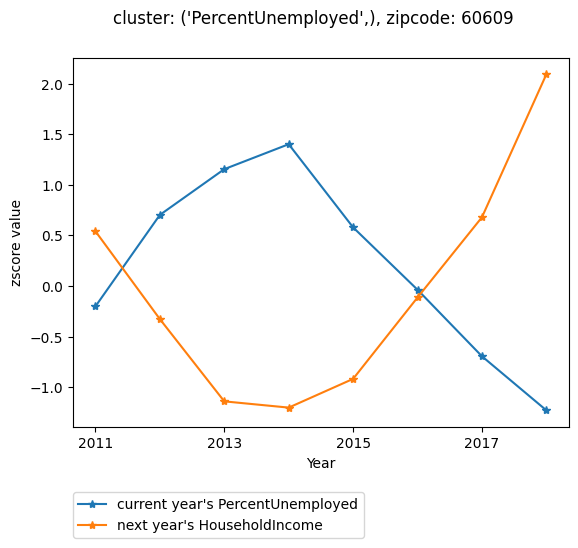

In [43]:
var_idx = plot_most_gc_entity(j, zc)

In [44]:
coint_test(var_idx, zc)

Test Statistic: -1.4938144794125137
P-value: 0.763556308220112
Critical Values: [-6.14522163 -4.34824633 -3.70584592]


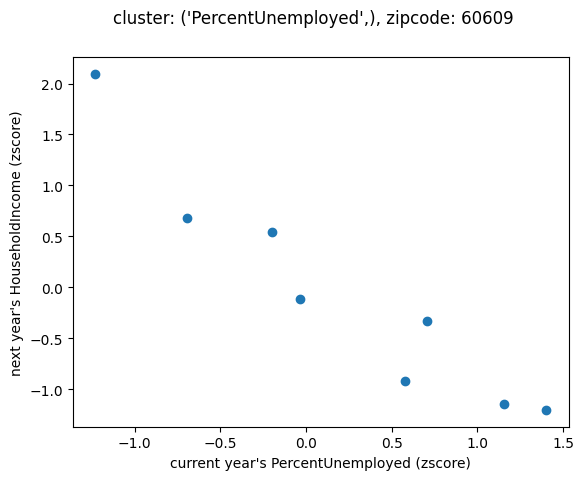

In [45]:
scatter_plot_of_most_gc_entity(var_idx, zc)

# Cluster 1

In [46]:
j = 1
zc = get_most_gc_entity(j)
zc

coefficients are: [0.60259098 0.75308658 0.38301101]


60639

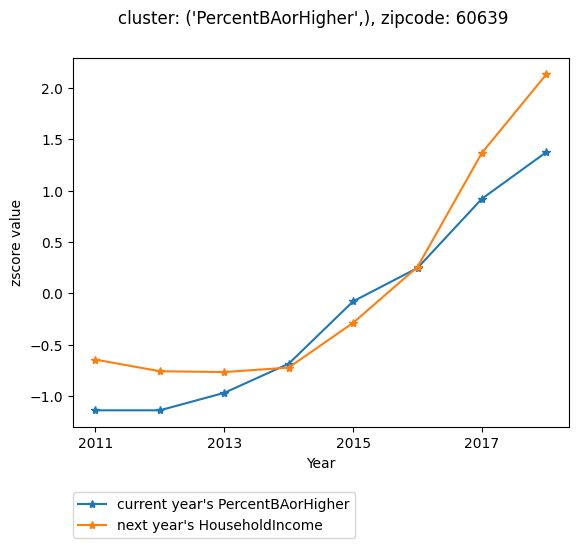

In [47]:
var_idx = plot_most_gc_entity(j, zc)

In [48]:
coint_test(var_idx, zc)

Test Statistic: -4.368087618966349
P-value: 0.002000658367243182
Critical Values: [-6.14522163 -4.34824633 -3.70584592]


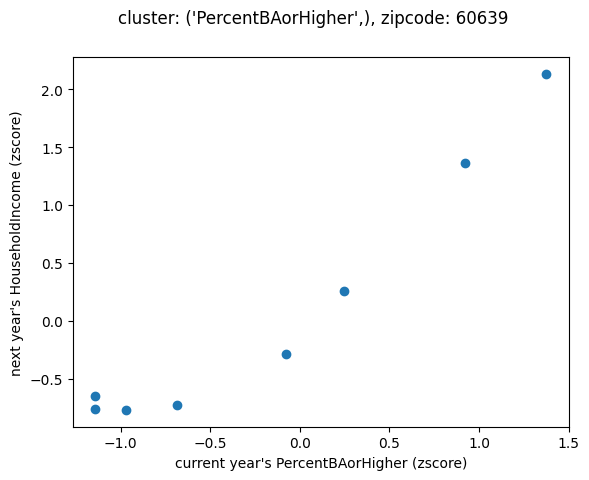

In [49]:
scatter_plot_of_most_gc_entity(var_idx, zc)

# Cluster 2

In [50]:
j = 2
zc = get_most_gc_entity(j)
zc

coefficients are: [-0.9699364   0.03490498  0.24041478]


60633

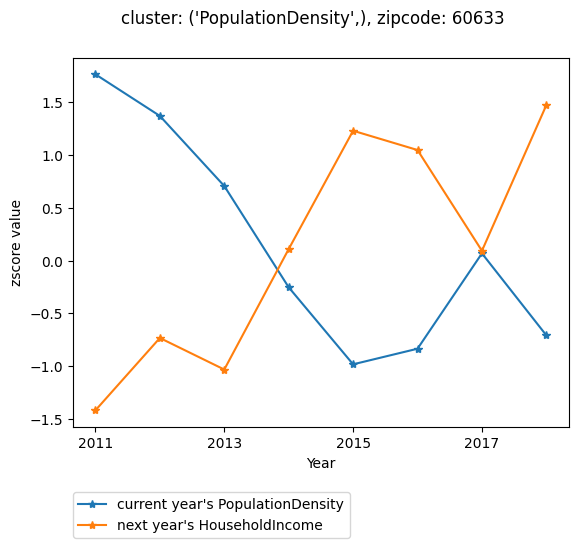

In [51]:
var_idx = plot_most_gc_entity(j, zc)

In [52]:
coint_test(var_idx, zc)

Test Statistic: -1.9507163775291538
P-value: 0.5540817616576513
Critical Values: [-6.14522163 -4.34824633 -3.70584592]


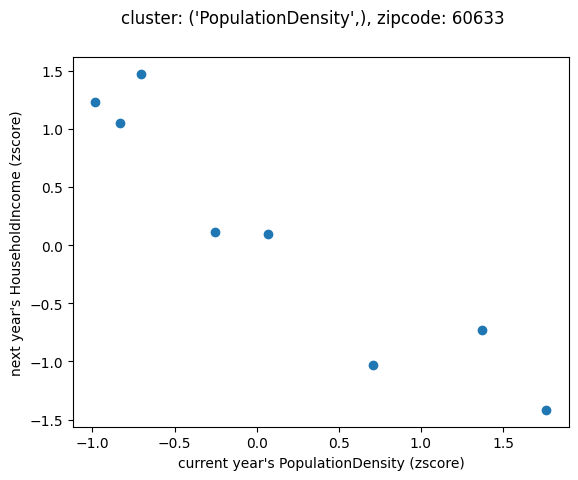

In [53]:
scatter_plot_of_most_gc_entity(var_idx, zc)